In [1]:
import os
import yaml
import json
import random
import pandas as pd
import pytz
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
seed = 42
set_seed(seed)

In [2]:
    
def process_sleep_data(df, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    #exclude where valud is HKCategoryValueSleepAnalysisInBed
    df = df.drop(df[df['value'] != 'HKCategoryValueSleepAnalysisInBed'].index)
    
    # Parse dates and times
    df['startDate'] = pd.to_datetime(df['startDate'])
    df['endDate'] = pd.to_datetime(df['endDate'])
    df['adjusted_startDate'] = df['startDate'] - pd.to_timedelta('12:00:00') # Subtract 12 hours from startDate

    # Group by date and find min startDate and max endDate
    df = df.groupby(df['adjusted_startDate'].dt.date).agg(startDate=('startDate', 'min'),endDate=('endDate', 'max')).reset_index(drop=True)
    df["value"] = 1 
    
    date_range = pd.date_range(start_date, end_date, freq=freq, tz = pytz.FixedOffset(-240))
    expanded_df = pd.DataFrame(date_range, columns=['date'])
    expanded_df['value'] = 0 # Start with 0 and replace with 1s if in interval

    for _, row in df.iterrows():
        mask = (expanded_df['date'] >= row['startDate']) & (expanded_df['date'] <= row['endDate'])
        expanded_df.loc[mask, 'value'] = row['value']
        
    expanded_df = expanded_df.rename(columns={'value': 'sleep'})

    return expanded_df

def preprocess_feature_data(df, col_name, freq='1min', start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00'):
    df = df[(df['startDate'] >= start_date) & (df['startDate'] <= end_date)]
    
    df = pd.melt(df, id_vars=['value'], value_vars=['startDate', 'endDate'], value_name='date')
    df = df.groupby('date', as_index=False).mean(numeric_only=True)
    df = df.sort_values(by='date')
    
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date')
    df = df.resample(freq).mean()
    
    df = df.interpolate().rolling(2).mean()
    df = df.fillna(method="bfill")
    
    df = df.reset_index()
    df = df.rename(columns={'date': 'date', 'value': col_name})
    
    return df

def create_lags(df, column_name, n_lags):
    bckwd_columns = [df[column_name].shift(i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
    fwd_columns = [df[column_name].shift(-i).fillna(method="bfill").fillna(method="ffill") for i in range(1, n_lags+1)]
    bckwd_names = [f"{column_name}_bckwd_{i}" for i in range(1, n_lags+1)]
    fwd_names = [f"{column_name}_fwd_{i}" for i in range(1, n_lags+1)]
    df_lags = pd.concat(bckwd_columns + fwd_columns, axis=1, keys=bckwd_names + fwd_names)
    return pd.concat([df, df_lags], axis=1)

In [3]:
features = [
    ('../data/xml_export/HeartRate.csv', "hr"),
    ('../data/xml_export/StepCount.csv', "steps"),
    ('../data/xml_export/DistanceWalkingRunning.csv', "distance"),
    ]

df = pd.DataFrame()
for file_path, col_name in features:
    raw = pd.read_csv(file_path, low_memory=False)
    preprocessed_df = preprocess_feature_data(raw, col_name, freq="1min", start_date='2020-09-26 00:00:00', end_date='2023-03-17 00:00:00')
    lagged_df = create_lags(preprocessed_df, col_name, 60)
    if df.empty:
        df = lagged_df
    else:
        df = pd.merge(df, lagged_df, on='date', how='outer')

df_sleep = pd.read_csv('../data/train_detailed.csv', low_memory=False)
df_sleep = process_sleep_data(df_sleep)

df = pd.merge(df_sleep, df, on='date', how='outer')
df = df.set_index("date")
df = df.astype('float32')

df = df.fillna(method='ffill').fillna(method='bfill')

print(df.head(2))

train = df[:'2021-12-31'] 
sub = df['2022-1-1':]

X, y = train.drop(columns=["sleep"]), train["sleep"]
sub_X = sub.drop(columns=["sleep"])
sub_start_dates = sub_X.index

                           sleep    hr  hr_bckwd_1  hr_bckwd_2  hr_bckwd_3  \
date                                                                         
2020-09-26 00:00:00-04:00    0.0  59.0        59.0        59.0        59.0   
2020-09-26 00:01:00-04:00    0.0  59.0        59.0        59.0        59.0   

                           hr_bckwd_4  hr_bckwd_5  hr_bckwd_6  hr_bckwd_7  \
date                                                                        
2020-09-26 00:00:00-04:00        59.0        59.0        59.0        59.0   
2020-09-26 00:01:00-04:00        59.0        59.0        59.0        59.0   

                           hr_bckwd_8  ...  distance_fwd_51  distance_fwd_52  \
date                                   ...                                     
2020-09-26 00:00:00-04:00        59.0  ...         0.018251         0.018215   
2020-09-26 00:01:00-04:00        59.0  ...         0.018251         0.018215   

                           distance_fwd_53  distance_fwd_

In [4]:
with open("sleep_model_best_params.json", "r") as f:
    sleep_model_best_params = json.load(f)
    
print("Best Parameters for New Model: ", sleep_model_best_params)

Best Parameters for New Model:  {'gamma': 0.05393989997704507, 'scaler': 'minmax', 'max_depth': 7, 'subsample': 0.5682998014333558, 'n_estimators': 359, 'learning_rate': 0.24268051240949223, 'colsample_bytree': 0.6071273304120464, 'min_child_weight': 4}


In [7]:
xgb_params = {
    "learning_rate": sleep_model_best_params["learning_rate"],
    "max_depth": sleep_model_best_params["max_depth"],
    "n_estimators": sleep_model_best_params["n_estimators"],
    "subsample": sleep_model_best_params["subsample"],
    "colsample_bytree": sleep_model_best_params["colsample_bytree"],
    "gamma": sleep_model_best_params["gamma"],
    "min_child_weight": sleep_model_best_params["min_child_weight"],
    "objective": "binary:logistic",
    "seed": seed
}

if sleep_model_best_params["scaler"] == "minmax":
    scaler = MinMaxScaler()
elif sleep_model_best_params["scaler"] == "standard":
    scaler = StandardScaler()
elif sleep_model_best_params["scaler"] == "robust":
    scaler = RobustScaler()
elif sleep_model_best_params["scaler"] == "none":
    scaler = None

model = xgb.XGBClassifier(**xgb_params, gpu_id=0, tree_method="gpu_hist", random_state=seed)

pipeline = Pipeline(steps=[("scaler", scaler), ("model", model)])

pipeline.fit(X, y)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6071273304120464,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0.05393989997704507,
                               gpu_id=0, grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.24268051240949223, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, n_estimators=359,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=42, ...))])

In [8]:
predictions = pipeline.predict_proba(sub_X)

predictions = pd.DataFrame({"startDate": sub_start_dates, "sleep_prob": predictions[:, 1]})

In [10]:
# First, convert the "startDate" to a datetime object
predictions["startDate"] = pd.to_datetime(predictions["startDate"])

# Shift the date back by 12 hours
predictions["shifted_date"] = predictions["startDate"] - pd.Timedelta(hours=12)

# Extract the date (without time) and create a new column called "date"
predictions["date"] = predictions["shifted_date"].dt.date

# Group the data by "date" and sum the "sleep_prob" values
sleep_hours = predictions.groupby("date")["sleep_prob"].sum()

# Multiply the sum by the time interval (minutes) and convert it to hours
sleep_hours = sleep_hours * 1 / 60

# Convert the sleep_hours to a DataFrame and reset the index
sleep_hours = sleep_hours.reset_index()
sleep_hours.columns = ["date", "sleep_hours_predicted"]

print(sleep_hours)

           date  sleep_hours_predicted
0    2021-12-31               5.652999
1    2022-01-01               6.991615
2    2022-01-02               6.384168
3    2022-01-03               6.750106
4    2022-01-04               8.148725
..          ...                    ...
436  2023-03-12               9.085063
437  2023-03-13               7.990170
438  2023-03-14               5.695815
439  2023-03-15               2.833699
440  2023-03-16               0.523080

[441 rows x 2 columns]


In [11]:
#replace < 2 with 6.666
sleep_hours.loc[sleep_hours['sleep_hours_predicted'] < 1, 'sleep_hours_predicted'] = 6.666

# fill na 
sleep_hours = sleep_hours.fillna(6.666)

# Drop first 1 day
sleep_hours = sleep_hours.iloc[1:]

In [12]:
sleep_hours

,date,sleep_hours_predicted
1,2022-01-01,6.991615
2,2022-01-02,6.384168
3,2022-01-03,6.750106
4,2022-01-04,8.148725
5,2022-01-05,4.979812
...,...,...
436,2023-03-12,9.085063
437,2023-03-13,7.990170
438,2023-03-14,5.695815
439,2023-03-15,2.833699


<Axes: >

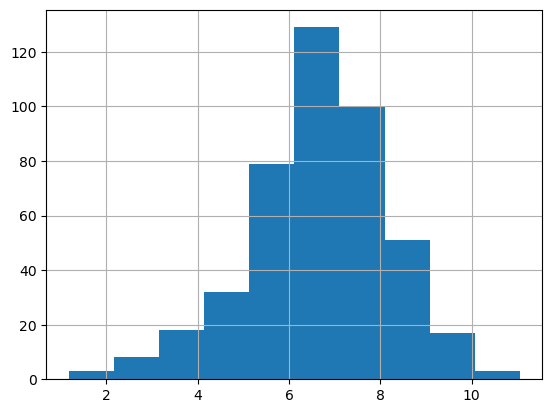

In [13]:
sleep_hours.sleep_hours_predicted.hist()

In [14]:
submission = pd.read_csv("../data/sample_submission.csv")
submission["date"] = submission["date"].astype(str)
sleep_hours["date"] = sleep_hours["date"].astype(str)
submission = submission.merge(sleep_hours, on="date", how="left")

# drop sleep hours
submission = submission.drop(columns=['sleep_hours'])

# rename sleep hours predicted 
submission = submission.rename(columns={'sleep_hours_predicted': 'sleep_hours'})


In [ ]:
submission["sleep_hours"] = (submission["sleep_hours"] + 6.666 *2)/3

In [15]:
submission.to_csv("prediction_sleep_hours.csv", index=False)